In [ ]:
# load Python packages
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from tqdm import tqdm
import xgboost
import shap

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# load Maze Ball dataset
mb_data = pd.read_json("./mazeball.json")
mb_data = mb_data.mazeball.apply(pd.Series)
# data entries
mb_data.keys()

Index(['demographics', 'games', 'tutorial'], dtype='object')

In [ ]:
# player demographics
# each entry contains demographic information for one player
p_demo = mb_data['demographics']
p_games = mb_data['games']
p_tutorial = mb_data['tutorial']
print("There are {} players in the dataset.".format(p_demo.shape))

There are (36,) players in the dataset.


In [ ]:
# let's take the first player as an example
player_no = 0
print("Player information: ")
print(p_demo[player_no])

p_games = mb_data['games']
print("Number of sets of games played by this player is {}".format(np.shape(p_games[player_no])))

Player information: 
{'player_id': 1, 'age': 26, 'male': 1, 'playgames': 1, 'playgamesfrequency': 5}
Number of sets of games played by this player is (4,)


In [ ]:
# let's take set 0 as an example
game_set_no = 0

# each entry contains game data and player preferences
p_games[player_no][game_set_no].keys()

dict_keys(['data', 'preferences'])

In [ ]:
p_games_data = p_games[player_no][game_set_no]['data']
p_games_pref = p_games[player_no][game_set_no]['preferences']

print("Information in data: ", p_games_data.keys())
print("Information in pref: ", p_games_pref.keys())

Information in data:  dict_keys(['A', 'B'])
Information in pref:  dict_keys(['anxiety', 'challenge', 'excitement', 'boredom', 'frustration', 'relaxation', 'fun'])


In [ ]:
# in each set, players played Game A and Game B
# for subjective ratings, players were asked whether they felt more "Anxiety" or "Challenge" etc when playing Game A or Game B
print(p_games_pref['anxiety'])
print(p_games_pref['challenge'])
print(p_games_pref['excitement'])
print(p_games_pref['boredom'])
print(p_games_pref['frustration'])
print(p_games_pref['relaxation'])
print(p_games_pref['fun'])

B
B
B
A
Both equally
Both equally
B


In [ ]:
print("Physiological signals include ", p_games_data['A'][game_set_no]['physio'].keys())

Physiological signals include  dict_keys(['SC', 'BVP', 'time'])


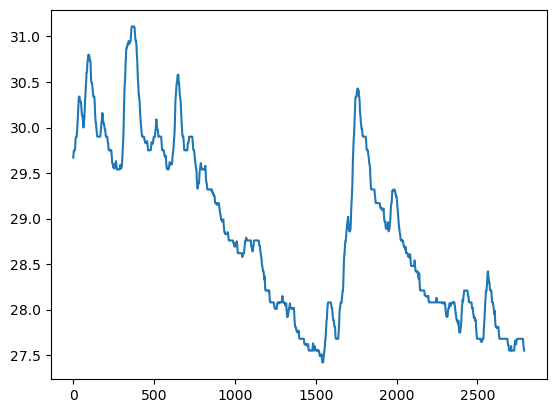

In [ ]:
sample_signal = p_games_data['A'][game_set_no]['physio']['SC']
plt.plot(sample_signal)

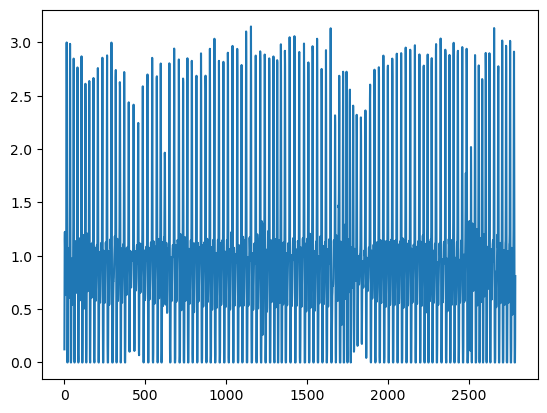

In [ ]:
sample_signal = p_games_data['A'][game_set_no]['physio']['BVP']
plt.plot(sample_signal)

In [ ]:
# time stamps for data recording; one sample measured every 0.03 seconds
# print(p_games_data['A'][game_set_no]['physio']['time'])
print("Sampling rate is {:.1f} Hz".format(1./p_games_data['A'][game_set_no]['physio']['time'][1]))

Sampling rate is 31.3 Hz


In [ ]:
# perform feature extraction on the SC signal and the BVP signal before classification
# extract features
df, info = nk.eda_process(p_games_data['A'][game_set_no]['physio']['SC'], sampling_rate=31)

features_sc = {
    'scr_amplitude_mean': np.nanmean(info['SCR_Amplitude']),
    'scr_amplitude_std': np.nanstd(info['SCR_Amplitude']),
    'scr_risetime_mean': np.nanmean(info['SCR_RiseTime']),
    'scr_risetime_std': np.nanstd(info['SCR_RiseTime']),
    'scr_recoverytime_mean': np.nanmean(info['SCR_RecoveryTime']),
    'scr_recoverytime_std': np.nanstd(info['SCR_RecoveryTime']),
}

In [ ]:
df, info = nk.ppg_process(p_games_data['A'][game_set_no]['physio']['BVP'], sampling_rate=31)
features_bvp = nk.ppg_intervalrelated(df, sampling_rate=31)
print(features_bvp)

   PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 81 columns]


In [ ]:
def extract_sc(signal):
    df, info = nk.eda_process(signal, sampling_rate=31)

    features_sc = np.array([
        np.nanmean(info['SCR_Amplitude']),
        np.nanstd(info['SCR_Amplitude']),
        np.nanmean(info['SCR_RiseTime']),
        np.nanstd(info['SCR_RiseTime']),
        np.nanmean(info['SCR_RecoveryTime']),
        np.nanstd(info['SCR_RecoveryTime'])
        ])

    feature_sc_names = [
        'SCR_Amplitude_mean',
        'SCR_Amplitude_std',
        'SCR_RiseTime_mean',
        'SCR_RiseTime_std',
        'SCR_RecoveryTime_mean',
        'SCR_RecoveryTime_std'
        ]

    return features_sc, feature_sc_names

def extract_bvp(signal):
    df, info = nk.ppg_process(p_games_data['A'][game_set_no]['physio']['BVP'], sampling_rate=31)
    feature_bvp = nk.ppg_intervalrelated(df, sampling_rate=31)
    feature_bvp_names = list(feature_bvp)

    return feature_bvp.to_numpy()[0], feature_bvp_names

In [ ]:
# Example of dataset collection to model emotion (i.e. "Anxiety", "Challenge")
# for each pairwise comparison, create two data points

In [ ]:
alldata = {
    # demographics
    'player_id': [],
    'player_age': [],
    'player_gender': [],
    'player_playgames': [],
    'player_playfrequency': [],

    # games
    'game_variant': [],
#     'features_gameplay': [],
#     'features_keystrokes': [],
    'features_sc': [],
    'features_bvp': [],

    'class': [], # anxiety, challenge, excitement, boredom, frustration, relaxation, fun
    }

for a in tqdm(range(36)): # player number
    player_demographics = p_demo[a] # player demographics
    player_game = p_games[a]
    player_tutorial = p_tutorial[a]

    for b in range(len(player_game)): # game number
        game_pref = p_games[a][b]['preferences']
        game_a = p_games[a][b]['data']['A'][0]
        game_b = p_games[a][b]['data']['B']

        # # Game A gameplay features
        # print(game_a['gameplay'].keys()) # in 90 seconds, how many data samples?

        # # Game A keystroke features
        # print(game_a['keystrokes'].keys()) # in 90 seconds, how many data samples?

        # # Game A physiological features
        # print(game_a['physio'].keys()) # in 90 seconds, how many data samples?
        features_sc_a, features_sc_names = extract_sc(game_a['physio']['SC'])
        features_bvp_a, features_bvp_names = extract_bvp(game_a['physio']['BVP'])

        # Game B physiological features
        features_sc_b, _ = extract_sc(game_b['physio']['SC'])
        features_bvp_b, _ = extract_bvp(game_b['physio']['BVP'])

        # which affective data to collect?
        c = "fun"

        # append information for Game A
        alldata['player_id'] += [player_demographics['player_id']]
        alldata['player_age'] += [player_demographics['age']]
        alldata['player_gender'] += [player_demographics['male']]
        alldata['player_playgames'] += [player_demographics['playgames']]
        alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]

        alldata['game_variant'] += [game_a['variant']]
        alldata['features_sc'] += [features_sc_a]
        alldata['features_bvp'] += [features_bvp_a]

        # append information for Game B
        alldata['player_id'] += [player_demographics['player_id']]
        alldata['player_age'] += [player_demographics['age']]
        alldata['player_gender'] += [player_demographics['male']]
        alldata['player_playgames'] += [player_demographics['playgames']]
        alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]

        alldata['game_variant'] += [game_a['variant']]
        alldata['features_sc'] += [features_sc_b]
        alldata['features_bvp'] += [features_bvp_b]

        # generate labels based on preference ranking
        if game_pref[c] == "A": # if game A is more preferred than game B
            alldata['class'] += [1] # class label for Game A
            alldata['class'] += [0] # class label for Game B

        elif game_pref[c] == "B": # if game B is more preferred
            alldata['class'] += [0]
            alldata['class'] += [1]

        elif game_pref[c] == "Both equally":
            alldata['class'] += [1]
            alldata['class'] += [1]

        elif game_pref[c] == "Neither":
            alldata['class'] += [0]
            alldata['class'] += [0]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:46<00:00,  1.30s/it]


In [ ]:
# create dataset
X = [] # training data
Y = [] # class label
Z = [] # player id for cross-validation
for i in range(len(alldata['class'])):
    vec = np.concatenate([
        np.array([alldata['player_age'][i],
                alldata['player_gender'][i],
                alldata['player_playgames'][i],
                alldata['player_playfrequency'][i],
                alldata['game_variant'][i]
            ]),
        alldata['features_sc'][i],
        alldata['features_bvp'][i],
        ])
    X += [vec.astype(float)]
    Y += [alldata['class'][i]]
    Z += [alldata['player_id'][i]]

feature_names = []
feature_names += ['player_age']
feature_names += ['player_gender']
feature_names += ['player_playgames']
feature_names += ['player_playfrequency']
feature_names += ['game_variant']
feature_names += features_sc_names
feature_names += features_bvp_names

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
player_id = np.unique(Z)

In [ ]:
# divide into training and testing;
# leave-one-person-out: X-1 persons for training, 1 person for testing
predictions = []
labels = []
for idx in player_id:
    istrain = Z!=idx
    istest = Z==idx

    X_train = X[istrain]
    X_test = X[istest]
    Y_train = Y[istrain]
    Y_test = Y[istest]

    # create a new model for each crossvalidation
    model_xgb = xgboost.XGBClassifier(eval_metric='logloss')
    model_xgb.fit(X_train, Y_train)

    # test the model
    Y_predicted = model_xgb.predict(X_test)

    predictions += [Y_predicted]
    labels += [Y_test]

In [ ]:
accuracy = np.mean(np.concatenate(predictions) == np.concatenate(labels))
print(accuracy)

0.4652777777777778


In [ ]:
model_xgb = xgboost.XGBClassifier()
model_xgb.fit(X, Y)

[03:17:25] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
xgboost.plot_tree(model_xgb)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

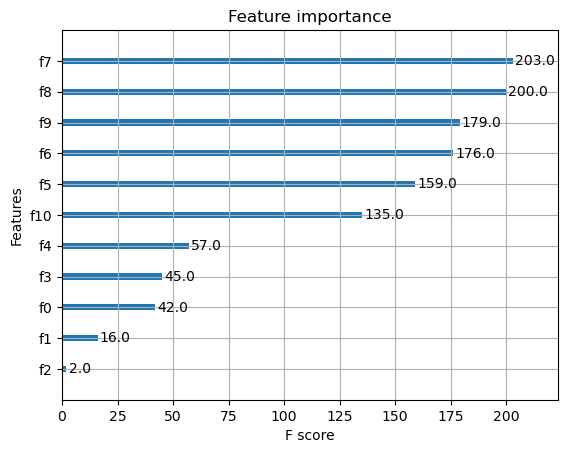

In [ ]:
model_xgb.feature_names=feature_names
xgboost.plot_importance(model_xgb)

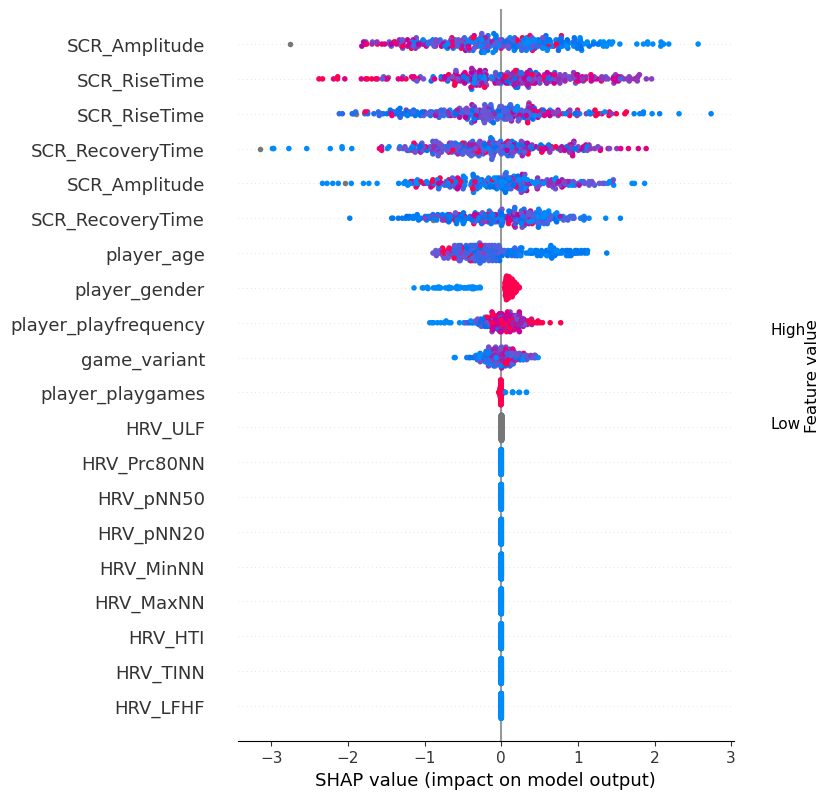

In [ ]:
model_explainable = shap.TreeExplainer(model_xgb, data=X)
shap_values = model_explainable.shap_values(X, Y)

In [ ]:
shap.summary_plot(shap_values, features=X, feature_names=feature_names)

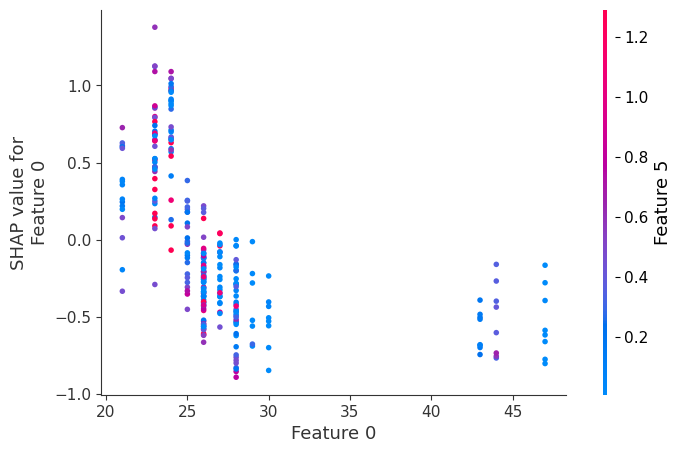

In [ ]:
shap.dependence_plot(0, shap_values, X)

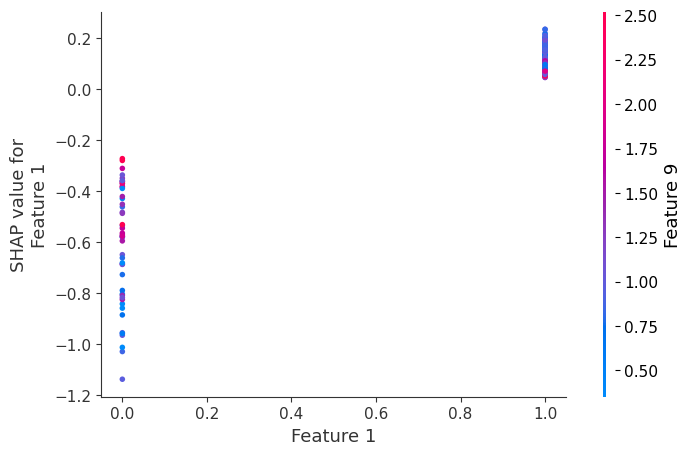

In [ ]:
shap.dependence_plot(1, shap_values, X)

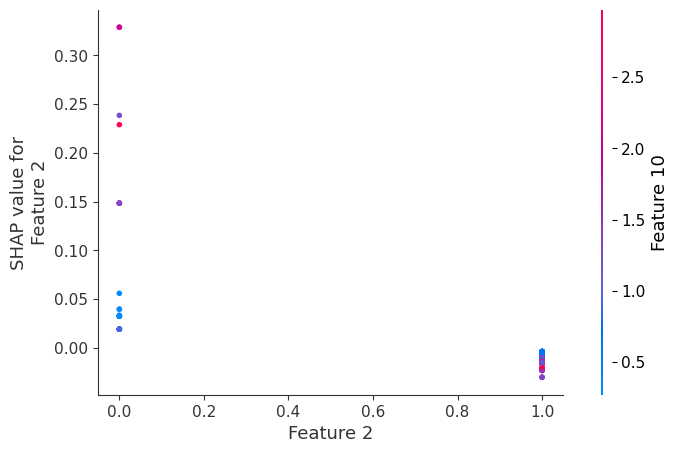

In [ ]:
shap.dependence_plot(2, shap_values, X)

In [ ]:
# How to improve the results?
# There are many modalities: game information, player information, and physiological information
# Which modality is more useful and which is less useful?
# Can the results be improved if the useless information are removed?